In [1]:
import ccxt
import itertools
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import ta
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
#import ace_tools as tools
%matplotlib inline

In [2]:
def fetch_bybit_data(symbol='BTC/USDT', timeframe='5m', limit=1000):
    exchange = ccxt.bybit({
        'options': {'defaultType': 'linear'}  # Required for USDT Perpetuals
    })
    exchange.load_markets()
    
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit, params = {"paginate": True})
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

In [3]:
df = fetch_bybit_data(timeframe='5m', limit=20000)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9990 entries, 2025-03-30 23:50:00 to 2025-05-04 17:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    9990 non-null   float64
 1   high    9990 non-null   float64
 2   low     9990 non-null   float64
 3   close   9990 non-null   float64
 4   volume  9990 non-null   float64
dtypes: float64(5)
memory usage: 468.3 KB


In [5]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-03-30 23:50:00,82300.9,82374.9,82211.7,82374.9,9.475027
2025-03-30 23:55:00,82374.9,82398.1,82298.1,82386.4,13.229494
2025-03-31 00:00:00,82386.4,82448.5,82310.4,82396.5,26.392737
2025-03-31 00:05:00,82396.5,82396.5,82170.5,82224.4,19.150529
2025-03-31 00:10:00,82224.4,82387.6,82218.7,82275.6,20.549897


In [6]:
fig = go.Figure()

# === Price Line ===
fig.add_trace(go.Scatter(
    x=df.index, y=df['close'],
    mode='lines', name='Price', line=dict(color='black')
))

fig.show()

In [7]:


# ========== Momentum Features ==========
df['return_1'] = df['close'].pct_change(1).shift(1)  # shifted to avoid leakage
df['return_3'] = df['close'].pct_change(3).shift(1)
df['return_5'] = df['close'].pct_change(5).shift(1)
df['return_10'] = df['close'].pct_change(10).shift(1)

df['roc_10'] = ta.momentum.ROCIndicator(close=df['close'], window=10).roc().shift(1)
df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi().shift(1)
df['macd_diff'] = ta.trend.MACD(close=df['close']).macd_diff().shift(1)

# ========== Volatility Features ==========
df['volatility_5'] = df['return_1'].rolling(window=5).std().shift(1)
df['volatility_10'] = df['return_1'].rolling(window=10).std().shift(1)
df['volatility_20'] = df['return_1'].rolling(window=20).std().shift(1)

df['atr_14'] = ta.volatility.AverageTrueRange(
    high=df['high'], low=df['low'], close=df['close'], window=14
).average_true_range().shift(1)

bb = ta.volatility.BollingerBands(close=df['close'], window=20)
df['bb_width'] = bb.bollinger_wband().shift(1)

df['volume_change'] = df['volume'].pct_change(1).shift(1)

# ========== Trend Features (EMA) ==========
df['ema_5'] = ta.trend.EMAIndicator(close=df['close'], window=5).ema_indicator().shift(1)
df['ema_10'] = ta.trend.EMAIndicator(close=df['close'], window=10).ema_indicator().shift(1)
df['ema_20'] = ta.trend.EMAIndicator(close=df['close'], window=20).ema_indicator().shift(1)

df['ema_slope_5'] = df['ema_5'].diff().shift(1)
df['ema_slope_10'] = df['ema_10'].diff().shift(1)
df['ema_slope_20'] = df['ema_20'].diff().shift(1)

df['price_vs_ema20'] = ((df['close'] - df['ema_20']) / df['ema_20']).shift(1)

# ========== Candle Pattern Features ==========
df['candle_body'] = (df['close'] - df['open']).abs().shift(1)
df['upper_wick'] = (df['high'] - df[['close', 'open']].max(axis=1)).shift(1)
df['lower_wick'] = (df[['close', 'open']].min(axis=1) - df['low']).shift(1)
df['body_to_range'] = (df['candle_body'] / (df['high'] - df['low'] + 1e-6)).shift(1)

# ========== Temporal Features ==========
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df['day_of_week'] = df.index.dayofweek

# Parameters
forward_window = 6  # e.g., 6 candles = 30 minutes for 5-min data
threshold = 0.002  # 0.2% return threshold

# Forward return (shifted to not leak future info)
df['future_return'] = (df['close'].shift(-forward_window) - df['close']) / df['close']

# Label based on return threshold
conditions = [
    df['future_return'] > threshold,     # significant upward move
    df['future_return'] < -threshold     # significant downward move
]
choices = [1, -1]  # 1 = uptrend (go long), -1 = downtrend (go short)

df['label'] = np.select(conditions, choices, default=0)

In [52]:
# Step 1: Smooth the price with EMA
df['smoothed'] = df['close'].ewm(span=10).mean()

# Step 2: Calculate forward return over a lookahead window
lookahead = 6  # ~30 minutes on 5-min candles
df['future_return'] = (df['smoothed'].shift(-lookahead) - df['smoothed']) / df['smoothed']

# Step 3: Label based on return thresholds
threshold = 0.005  # 0.5%
df['raw_label'] = np.select(
    [df['future_return'] > threshold, df['future_return'] < -threshold],
    [1, -1],
    default=0
)

# Step 4: Debounce: remove repeated signals and require spacing
min_spacing = 6  # require at least 6 bars between signals
labels = df['raw_label'].copy()
for i in range(1, len(labels)):
    if labels.iloc[i] == labels.iloc[i-1]:
        labels.iloc[i] = 0
    elif labels.iloc[i] != 0:
        labels.iloc[i+1:i+min_spacing] = 0  # suppress next few

df['label'] = labels


In [53]:
df['label'].value_counts()

label
 0    9839
 1      57
-1      48
Name: count, dtype: int64

In [55]:
# Create Plotly interactive plot
fig = go.Figure()

# Close Price Line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['close'],
    mode='lines',
    name='Close Price',
    line=dict(color='black')
))

# Long Signals
fig.add_trace(go.Scatter(
    x=df.index[df['label'] == 1],
    y=df['close'][df['label'] == 1],
    mode='markers',
    name='Long Signal',
    marker=dict(color='green', symbol='triangle-up', size=10)
))

# Short Signals
fig.add_trace(go.Scatter(
    x=df.index[df['label'] == -1],
    y=df['close'][df['label'] == -1],
    mode='markers',
    name='Short Signal',
    marker=dict(color='red', symbol='triangle-down', size=10)
))

# Layout
fig.update_layout(
    title='BTCUSDT Close Price with Long/Short Signals (Interactive)',
    xaxis_title='Time',
    yaxis_title='Price',
    legend=dict(x=0, y=1),
    height=600
)

fig.show()

In [56]:
# Drop any NaNs
df.dropna(inplace=True)

# 🔁 Map labels to 0, 1, 2 for XGBoost
label_map = {-1: 0, 0: 1, 1: 2}
df['label_encoded'] = df['label'].map(label_map)

In [57]:
df['label_encoded'].value_counts()

label_encoded
1    9833
2      57
0      48
Name: count, dtype: int64

In [34]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return_1', 'return_3',
       'return_5', 'return_10', 'roc_10', 'rsi_14', 'macd_diff',
       'volatility_5', 'volatility_10', 'volatility_20', 'atr_14', 'bb_width',
       'volume_change', 'ema_5', 'ema_10', 'ema_20', 'ema_slope_5',
       'ema_slope_10', 'ema_slope_20', 'price_vs_ema20', 'candle_body',
       'upper_wick', 'lower_wick', 'body_to_range', 'hour_sin', 'hour_cos',
       'day_of_week', 'future_return', 'label', 'label_encoded', 'smoothed',
       'raw_label'],
      dtype='object')

In [58]:
# Define features and labels
X = df[['return_1', 'return_3',
       'return_5', 'return_10', 'roc_10', 'rsi_14', 'macd_diff',
       'volatility_5', 'volatility_10', 'volatility_20', 'atr_14', 'bb_width',
       'volume_change', 'ema_5', 'ema_10', 'ema_20', 'ema_slope_5',
       'ema_slope_10', 'ema_slope_20', 'price_vs_ema20', 'candle_body',
       'upper_wick', 'lower_wick', 'body_to_range', 'hour_sin', 'hour_cos',
       'day_of_week']]
y = df['label_encoded']

In [67]:
# Time-based train/test split (no shuffling)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [68]:
weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [69]:

model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    max_depth= 4,
    learning_rate=0.05,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [72]:
print(y_train.value_counts())

label_encoded
1    7847
2      57
0      46
Name: count, dtype: int64


In [70]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [71]:
print(classification_report(y_test, y_pred, labels=[-1, 0, 1], target_names=['Downtrend', 'Neutral', 'Uptrend']))

              precision    recall  f1-score   support

   Downtrend       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         2
     Uptrend       1.00      1.00      1.00      1986

    accuracy                           1.00      1988
   macro avg       0.33      0.33      0.33      1988
weighted avg       1.00      1.00      1.00      1988



/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.

In [39]:
def predict_with_threshold(probs, up_thresh=0.6, down_thresh=0.6):
    preds = []
    for p in probs:
        if p[2] > up_thresh:
            preds.append(2)   # uptrend
        elif p[0] > down_thresh:
            preds.append(0)   # downtrend
        else:
            preds.append(1)   # neutral (no trade)
    return preds

In [40]:
probs = model.predict_proba(X_test)

In [41]:
y_pred_thresh = predict_with_threshold(probs, up_thresh=0.55, down_thresh=0.55)

In [46]:
print(classification_report(y_test, y_pred_thresh, labels=[-1, 0, 1], target_names=['Downtrend', 'Neutral', 'Uptrend']))

              precision    recall  f1-score   support

   Downtrend       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         2
     Uptrend       1.00      1.00      1.00      1987

    accuracy                           1.00      1989
   macro avg       0.33      0.33      0.33      1989
weighted avg       1.00      1.00      1.00      1989



/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/Users/stevenyoungkin/Documents/trading/python/bybit_algo_trading/venv/lib/python3.

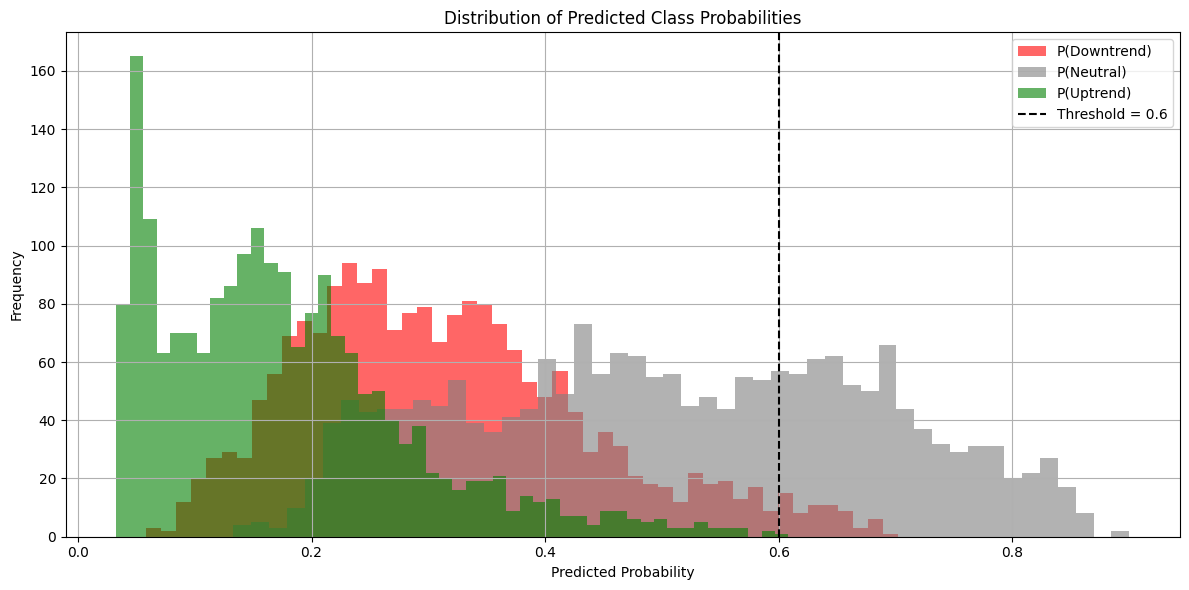

In [ ]:
# Extract probabilities for each class
p_downtrend = probs[:, 0]
p_neutral = probs[:, 1]
p_uptrend = probs[:, 2]

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(p_downtrend, bins=50, alpha=0.6, label='P(Downtrend)', color='red')
plt.hist(p_neutral, bins=50, alpha=0.6, label='P(Neutral)', color='gray')
plt.hist(p_uptrend, bins=50, alpha=0.6, label='P(Uptrend)', color='green')

plt.axvline(x=0.6, color='black', linestyle='--', label='Threshold = 0.6')
plt.title("Distribution of Predicted Class Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Parameter grid
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Prepare results logging
results = []

# Loop through all combinations
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Compute sample weights to handle imbalance
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Train model
    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        **param_dict
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save results
    results.append({
        **param_dict,
        'accuracy': acc,
        'macro_f1': macro_f1,
        'downtrend_f1': report['0']['f1-score'],
        'neutral_f1': report['1']['f1-score'],
        'uptrend_f1': report['2']['f1-score']
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
#tools.display_dataframe_to_user(name="XGBoost Hyperparameter Tuning Results", dataframe=results_df)

KeyError: '2'

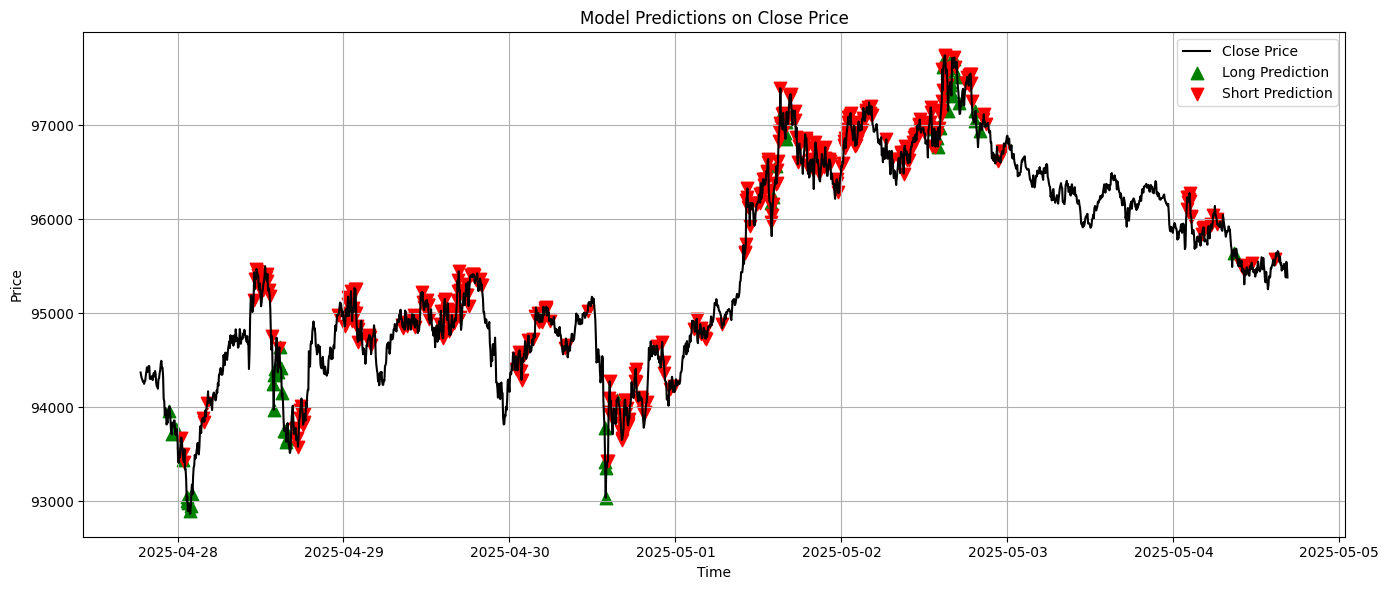

In [ ]:
# Make sure the test set has the corresponding timestamps
test_prices = df.iloc[split_idx:].copy()  # same split index as train/test
test_prices['pred'] = y_pred

# Map predicted class back to action label: 2 → 1 (long), 0 → -1 (short)
label_map_back = {0: -1, 1: 0, 2: 1}
test_prices['pred_signal'] = test_prices['pred'].map(label_map_back)

# Plot close price
plt.figure(figsize=(14, 6))
plt.plot(test_prices.index, test_prices['close'], label='Close Price', color='black')

# Plot long entries (pred_signal == 1)
plt.scatter(test_prices.index[test_prices['pred_signal'] == 1],
            test_prices['close'][test_prices['pred_signal'] == 1],
            label='Long Prediction', marker='^', color='green', s=80)

# Plot short entries (pred_signal == -1)
plt.scatter(test_prices.index[test_prices['pred_signal'] == -1],
            test_prices['close'][test_prices['pred_signal'] == -1],
            label='Short Prediction', marker='v', color='red', s=80)

plt.title("Model Predictions on Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()